## Introduction to LoRA
- Low-rank adaption (LoRA) is a machine learning technique that modifies a pretrained model to better suit a specific, often smaller, dataset by adjusting a small, low-rank subset of the model's parameters 
- This approach is important because it allows for efficient finetuning of large models on task-specific data, significantly reducing the computational cost and time required for finetuning
- Suppose we have a large weight matrix $W$ for a given layer
- During backpropagation, we learn a $\Delta W$ matrix, which contains information on how much we want to update the original weights to minimize the loss function during training: $W_\text{updated}=W+\Delta W$

In [2]:
from pathlib import Path
import pandas as pd
from previous_chapters2 import (
    download_and_unzip_spam_data,
    create_balanced_dataset,
    random_split
)


url = "https://archive.ics.uci.edu/static/public/228/sms+spam+collection.zip"
zip_path = "sms_spam_collection.zip"
extracted_path = "sms_spam_collection"
data_file_path = Path(extracted_path) / "SMSSpamCollection.tsv"

download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path)

df = pd.read_csv(data_file_path, sep="\t", header=None, names=["Label", "Text"])
balanced_df = create_balanced_dataset(df)
balanced_df["Label"] = balanced_df["Label"].map({"ham": 0, "spam": 1})

train_df, validation_df, test_df = random_split(balanced_df, 0.7, 0.1)
train_df.to_csv("train.csv", index=None)
validation_df.to_csv("validation.csv", index=None)
test_df.to_csv("test.csv", index=None)

File downloaded and saved as sms_spam_collection/SMSSpamCollection.tsv


In [4]:
import torch
from torch.utils.data import Dataset
import tiktoken
from previous_chapters2 import SpamDataset


tokenizer = tiktoken.get_encoding("gpt2")
train_dataset = SpamDataset("train.csv", max_length=None, tokenizer=tokenizer)
val_dataset = SpamDataset("validation.csv", max_length=train_dataset.max_length, tokenizer=tokenizer)
test_dataset = SpamDataset("test.csv", max_length=train_dataset.max_length, tokenizer=tokenizer)

In [5]:
from torch.utils.data import DataLoader

num_workers = 0
batch_size = 8

torch.manual_seed(123)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    drop_last=True,
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)

In [6]:
from gpt_download import download_and_load_gpt2
from previous_chapters2 import GPTModel, load_weights_into_gpt


CHOOSE_MODEL = "gpt2-small (124M)"
INPUT_PROMPT = "Every effort moves"

BASE_CONFIG = {
    "vocab_size": 50257,     # Vocabulary size
    "context_length": 1024,  # Context length
    "drop_rate": 0.0,        # Dropout rate
    "qkv_bias": True         # Query-key-value bias
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
settings, params = download_and_load_gpt2(model_size=model_size, models_dir="gpt2")

model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval()

2024-06-23 14:04:33.045115: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
checkpoint: 100%|██████████| 77.0/77.0 [00:00<00:00, 16.0kiB/s]
encoder.json: 100%|██████████| 1.04M/1.04M [00:00<00:00, 1.16MiB/s]
hparams.json: 100%|██████████| 90.0/90.0 [00:00<00:00, 113kiB/s]
model.ckpt.data-00000-of-00001: 100%|██████████| 498M/498M [01:54<00:00, 4.36MiB/s]  
model.ckpt.index: 100%|██████████| 5.21k/5.21k [00:00<00:00, 1.79MiB/s]
model.ckpt.meta: 100%|██████████| 471k/471k [00:00<00:00, 828kiB/s] 
vocab.bpe: 100%|██████████| 456k/456k [00:00<00:00, 673kiB/s] 


GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_resid): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768,

In [7]:
from previous_chapters2 import (
    generate_text_simple,
    text_to_token_ids,
    token_ids_to_text
)


text_1 = "Every effort moves you"

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(text_1, tokenizer),
    max_new_tokens=15,
    context_size=BASE_CONFIG["context_length"]
)

print(token_ids_to_text(token_ids, tokenizer))

Every effort moves you forward.

The first step is to understand the importance of your work


In [8]:
torch.manual_seed(123)

num_classes = 2
model.out_head = torch.nn.Linear(in_features=768, out_features=num_classes)

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device);  # no assignment model = model.to(device) necessary for nn.Module classes

In [11]:
from previous_chapters2 import calc_accuracy_loader


torch.manual_seed(123)
train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=10)
val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=10)
test_accuracy = calc_accuracy_loader(test_loader, model, device, num_batches=10)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 46.25%
Validation accuracy: 45.00%
Test accuracy: 48.75%


## Parameter-efficient finetuning with LoRA
- We begin with a LoRA Layer that creates the matrices $A$ and $B$, along with the `alpha` scaling hyperparameter and the `rank` $(r)$ hyperparameters
- This layer can accept an input and compute the corresponding output

In [12]:
import math

class LoRALayer(torch.nn.Module):
    def __init__(self, in_dim, out_dim, rank, alpha):
        super().__init__()
        self.A = torch.nn.Parameter(torch.empty(in_dim, rank))
        torch.nn.init.kaiming_uniform_(self.A, a=math.sqrt(5)) # similar to standard weight initialization
        self.B = torch.nn.Parameter(torch.zeros(rank, out_dim))
        self.alpha = alpha

    def forward(self, x):
        x = self.alpha * (x @ self.A @ self.B)
        return x

- Here, `rank` controls the inner dimensions of the matrices $A$ and $B$
- In other words, this parameter controls the number of additional parameters intoduced by LoRA and is a key factor in determining the balance between model adaptability and parameter efficiency
- `Alpha` is a scaling hyperparameter applied to the output of the low-rank adaption
- it contols the extent to which the adapted layer's output is allowed to influece the original output of the layer being adapted
- This can be seen as a way to regulate the impact of the low-rank adaptation on the layer's output
- We are usually interested in replacing existing `Linear` layers so that the weight update is applied to the existing pretrained weights


- To incorporate the original `Linear` layer weights as shown in the figure above, we implement a `LinearWithLoRA` layer that uses the implemented `LoRALayer` and can be used to replace existing `Linear` layers in a neural network, e.g. self-attention module or feed forward modules in an LLM

In [13]:
class LinearWithLoRA(torch.nn.Module):
    def __init__(self, linear, rank, alpha):
        super().__init__()
        self.linear = linear
        self.lora = LoRALayer(
            linear.in_features, linear.out_features, rank, alpha
        )
    
    def forward(self, x):
        return self.linear(x) + self.lora(x)

- Note, we initialized the weight matrix $B$ in the `LoRALayer` with zeros values. The matrix multiplication between $A$ and $B$ results in a matrix consisting of 0's and doesn't affect the original weights (since adding 0 weights doesn't modify them)

In [14]:
def replace_linear_with_lora(model, rank, alpha):
    for name, module in model.named_children():
        if isinstance(module, torch.nn.Linear):
            # Replace the Linear layer with LinearWithLoRA
            setattr(model, name, LinearWithLoRA(module, rank, alpha))
        else:
            # Recursively apply the same function to child modules
            replace_linear_with_lora(module, rank, alpha)

- We then freeze the original model parameter and use the `replace_linear_with_lora` to replace the said `Linear` layers

In [19]:
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total trainable parameters before: ", total_params)

for param in model.parameters():
    param.requires_grad = False

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total trainable params after: ", total_params)

Total trainable parameters before:  7999584
Total trainable params after:  0


In [20]:
replace_linear_with_lora(model, rank=16, alpha=16)

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable LoRA parameters: {total_params:,}")

Total trainable LoRA parameters: 2,666,528


In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(model)

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): LinearWithLoRA(
          (linear): LinearWithLoRA(
            (linear): LinearWithLoRA(
              (linear): LinearWithLoRA(
                (linear): Linear(in_features=768, out_features=768, bias=True)
                (lora): LoRALayer()
              )
              (lora): LoRALayer()
            )
            (lora): LoRALayer()
          )
          (lora): LoRALayer()
        )
        (W_key): LinearWithLoRA(
          (linear): LinearWithLoRA(
            (linear): LinearWithLoRA(
              (linear): LinearWithLoRA(
                (linear): Linear(in_features=768, out_features=768, bias=True)
                (lora): LoRALayer()
              )
              (lora): LoRALayer()
            )
            (lora): LoRALayer()
          )
       

- we have now 50x less parameters when using LoRA

In [22]:
torch.manual_seed(123)
train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=10)
val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=10)
test_accuracy = calc_accuracy_loader(test_loader, model, device, num_batches=10)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 46.25%
Validation accuracy: 45.00%
Test accuracy: 48.75%


In [24]:
import time
from previous_chapters2 import train_classifier_simple


start_time = time.time()

torch.manual_seed(123)

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.1)

num_epochs = 5
train_losses, val_losses, train_accs, val_accs, examples_seen = train_classifier_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=50, eval_iter=5,
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 3.563, Val loss 3.216
Ep 1 (Step 000050): Train loss 0.355, Val loss 0.330
Ep 1 (Step 000100): Train loss 0.166, Val loss 0.389
Training accuracy: 97.50% | Validation accuracy: 100.00%
Ep 2 (Step 000150): Train loss 0.218, Val loss 0.061
Ep 2 (Step 000200): Train loss 0.029, Val loss 0.046
Ep 2 (Step 000250): Train loss 0.207, Val loss 0.049
Training accuracy: 97.50% | Validation accuracy: 95.00%
Ep 3 (Step 000300): Train loss 0.070, Val loss 0.136
Ep 3 (Step 000350): Train loss 0.014, Val loss 0.052
Training accuracy: 100.00% | Validation accuracy: 97.50%
Ep 4 (Step 000400): Train loss 0.006, Val loss 0.127
Ep 4 (Step 000450): Train loss 0.043, Val loss 0.532
Ep 4 (Step 000500): Train loss 0.030, Val loss 0.069
Training accuracy: 97.50% | Validation accuracy: 95.00%
Ep 5 (Step 000550): Train loss 0.113, Val loss 0.058
Ep 5 (Step 000600): Train loss 0.014, Val loss 0.108
Training accuracy: 100.00% | Validation accuracy: 97.50%
Training completed in 63.12 

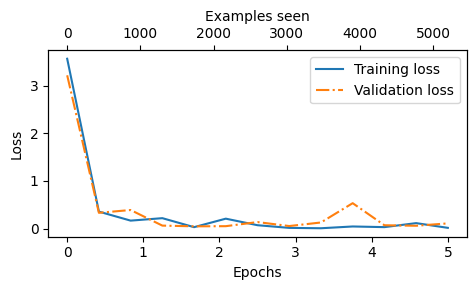

In [25]:
from previous_chapters2 import plot_values

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_losses))

plot_values(epochs_tensor, examples_seen_tensor, train_losses, val_losses, label="loss")

In [26]:
train_accuracy = calc_accuracy_loader(train_loader, model, device)
val_accuracy = calc_accuracy_loader(val_loader, model, device)
test_accuracy = calc_accuracy_loader(test_loader, model, device)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 98.56%
Validation accuracy: 97.99%
Test accuracy: 95.00%
